- Andere Metriken als confusion matrix benutzen (Classification Metric mit TF,TN,FP,FN)
- Bilder zwischenspeichern nach der Bearbeitung -erledigt
- Model speichern nach dem Trainieren -erledigt aber vielleicht besser in einer anderen datei?
- testen, ob bestimmte hunderassen besser erkannt werden als andere
- evtl Code besser strukturieren/Aufteilen in verschiedene Dateien bzw Klassen
- Streamlit WebApp verbssern. Z.B. Bilder wieder entfernen nachdem man diese überprüft hat, vielleicht Statistiken zu dem Modell/Datensatz...
- ReadMe befüllen mit unser kompletten Doku was wir machen, auch relativ ausführlich
- https://github.com/ypwhs/DogBreed_gluon
- train Datensatz aufteilen fürs trainieren und testen
- Prozente in der WebApp angeben

In [1]:
%pip install tensorflow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Konstanten setzen
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.7
#EPOCHS = 5

In [3]:
#Füllen der Variablen train_dir und test_dir mit den Pfaden zu den Trainings- und Testdaten
train_dir ='input/train'
test_dir ='input/test'

In [4]:
# Anzahl der Bilder im Trainings- und Testset
train_size = len(os.listdir('input/train'))
test_size = len(os.listdir('input/test'))

train_size,test_size

(10222, 10357)

In [5]:
#Füllen der Variablen train_images und test_images mit den Bilddaten
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        with Image.open(path) as img:
            #Aktivieren, wenn neue Bilder hinzugefügt werden sollen
            #img = img.resize((224, 224))  # Einheitliche Größe
            images[filename] = np.array(img)
    return images

# Bilder laden
#train_images = load_images_from_folder(train_dir)
#test_images = load_images_from_folder(test_dir)

In [40]:

class ImageSave:
    def __init__(self, test_images, train_images, processed_test_dir="processed/test", processed_train_dir="processed/train"):
        self.test_images = test_images
        self.train_images = train_images
        self.processed_test_dir = processed_test_dir
        self.processed_train_dir = processed_train_dir

    def save_images(self):
        # Speichern der Testbilder
        for filename, image_array in self.test_images.items():
            img = Image.fromarray(image_array.astype('uint8'))
            save_path = os.path.join(self.processed_test_dir, filename)
            img.save(save_path)
        print(f"{len(self.test_images)} verarbeitete Bilder in '{self.processed_test_dir}' gespeichert.")

        # Speichern der Trainingsbilder
        for filename, image_array in self.train_images.items():
            img = Image.fromarray(image_array.astype('uint8'))
            save_path = os.path.join(self.processed_train_dir, filename)
            img.save(save_path)
        print(f"{len(self.train_images)} verarbeitete Bilder in '{self.processed_train_dir}' gespeichert.")

In [9]:
img_saver = ImageSave(test_images, train_images)
img_saver.save_images()

NameError: name 'ImageSave' is not defined

In [6]:
# bearbeitete Bilder in Datei laden
test_images = load_images_from_folder("processed/test")
train_images = load_images_from_folder("processed/train")

In [7]:
#Ausgabe der ersten 5 Bilder aus der csv-Datei
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
#Anzeigen der Klassen (Hunderassen) und der Anzahl der Klassen
dog_breeds = sorted(df['breed'].unique())
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds

120


['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [8]:
#Converting classes to numbers
#class_to_num = dict(zip(dog_breeds,range(n_classes)))

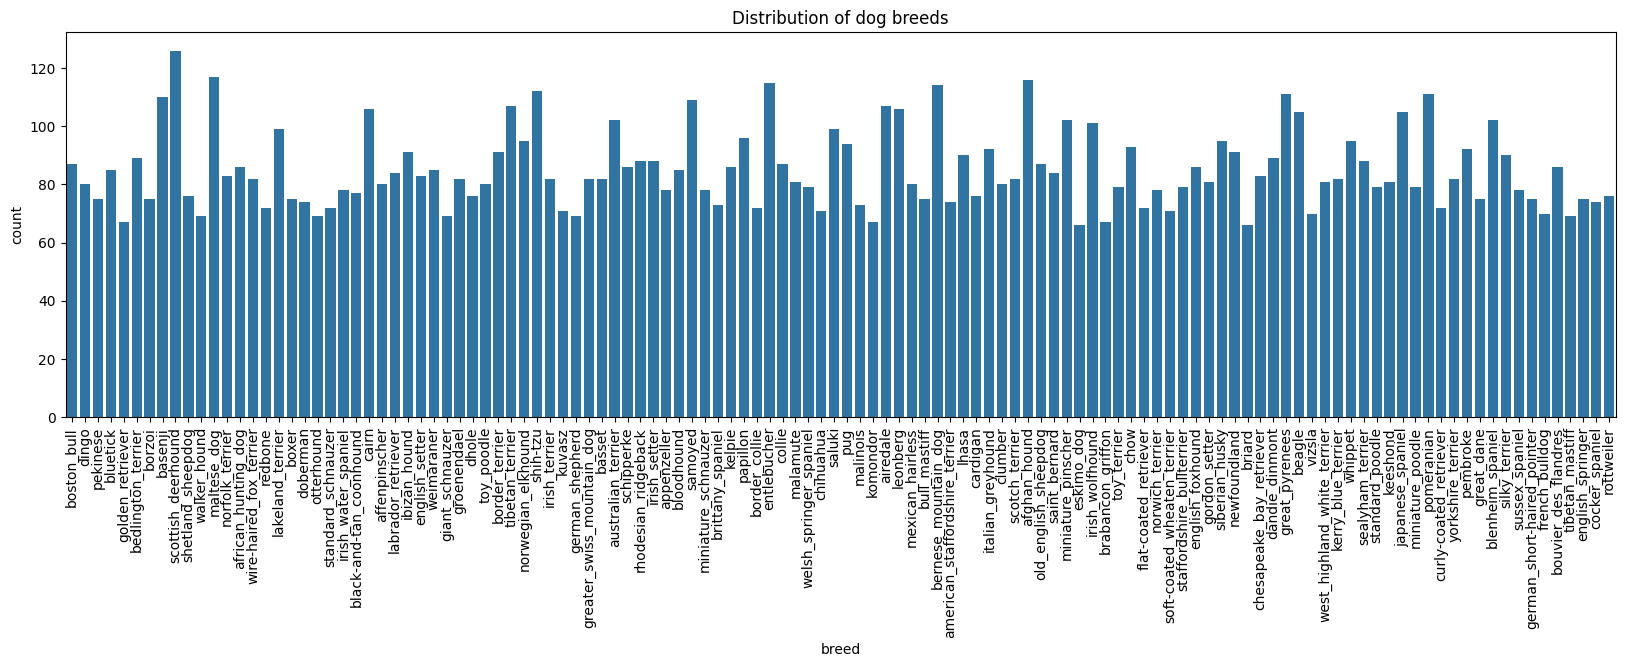

In [9]:
#Anzeigen der Verteilung der Klassen
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.countplot(data=df, x='breed')
plt.title('Distribution of dog breeds')
plt.show()

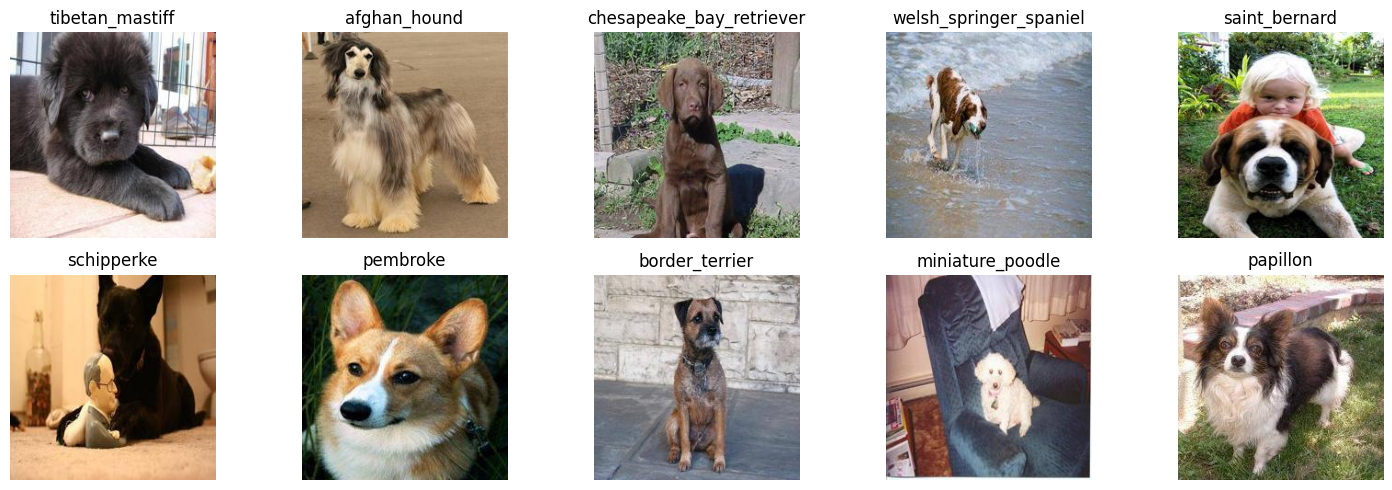

In [10]:
#Sample 10 Bilder aus dem Trainingsset und Anzeigen der Hunderasse
sample_df = df.sample(10)
rows = 2
cols = 5

plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(sample_df.iterrows()):
    filename = (row['id'] + '.jpg').lower()
    breed = row['breed']
    image = train_images.get(filename)
    
    if image is not None:
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(breed)
        plt.axis('off')
    else:
        print(f"Bild nicht gefunden: {filename}")

plt.tight_layout()
plt.show()

Ab Hier chatgpt -> Vielleicht bisschen quatschig

In [11]:
# Verknüpfen der Bilder mit Labels
X = []
y = []

# Nur den Namen ohne Erweiterung vergleichen
df['id'] = df['id'].str.replace('.jpg', '', regex=False)  # falls nötig

for filename, image in train_images.items():
    file_id = os.path.splitext(filename)[0]  # z. B. "abc123" aus "abc123.jpg"
    
    if file_id in df['id'].values:
        label = df[df['id'] == file_id]['breed'].values[0]
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [12]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

In [14]:
X_train = X_train / 255.0
X_val = X_val / 255.0

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(y_categorical.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False  # Freeze pre-trained layers

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 184s 697ms/step - accuracy: 0.0593 - loss: 4.5887 - val_accuracy: 0.3169 - val_loss: 3.4884
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 162s 635ms/step - accuracy: 0.4251 - loss: 3.0203 - val_accuracy: 0.5819 - val_loss: 2.0741
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 162s 631ms/step - accuracy: 0.6422 - loss: 1.7577 - val_accuracy: 0.6494 - val_loss: 1.4826
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 155s 606ms/step - accuracy: 0.7160 - loss: 1.2608 - val_accuracy: 0.6944 - val_loss: 1.2320
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 149s 584ms/step - accuracy: 0.7609 - loss: 1.0192 - val_accuracy: 0.7120 - val_loss: 1.1058
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 149s 582ms/step - accuracy: 0.7826 - loss: 0.8684 - val_accuracy: 0.7247 - val_loss: 1.0197
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 146s 572ms/step - accuracy: 0.8141 - loss: 0.7598 - val_accuracy: 0.7227 - val_loss: 0.9775
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 145s 565ms/step - accuracy: 0.8183 -

In [16]:
#Ausführen um variable model mit Model zu füllen
from tensorflow.keras.models import load_model

# Modell aus der HDF5-Datei laden
model = load_model("hundemodell.h5")

In [17]:
# Modell-Vorhersagen
y_pred = model.predict(X_val)

# Umwandeln in Klassen-Index
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 332ms/step


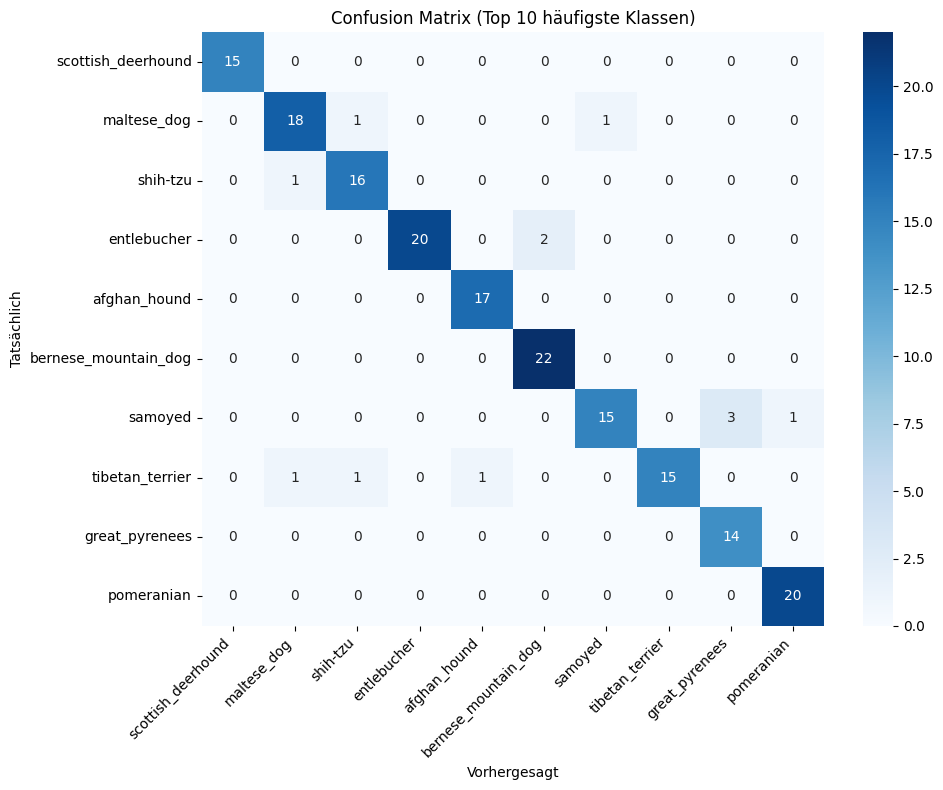

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Verwirrungsmatrix berechnen
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Nur die häufigsten N Klassen anzeigen
N = 10
class_counts = np.bincount(y_true_classes)
top_classes_idx = np.argsort(class_counts)[::-1][:N]
top_labels = le.classes_[top_classes_idx]

# Verwirrungsmatrix für Top-N Klassen extrahieren
cm_top = cm[np.ix_(top_classes_idx, top_classes_idx)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_top, annot=True, fmt="d", cmap="Blues", xticklabels=top_labels, yticklabels=top_labels)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(f"Confusion Matrix (Top {N} häufigste Klassen)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
model.save("hundemodell.h5")  # Speichert das gesamte Modell (Architektur + Gewichte)
import pickle

# Speichern des LabelEncoders
with open("labelencoder.pkl", "wb") as f:
    pickle.dump(le, f)